### **Some installations and other stuff**

In [ ]:
from huggingface_hub import login

login()

In [ ]:
import gc
import os
import torch

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!nvidia-smi

Tue Apr 22 10:09:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -U fsspec==2024.10.0
!pip install -q accelerate peft bitsandbytes transformers trl
!pip install nltk
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


### **Dataset**

In [ ]:
import json
from sklearn.model_selection import train_test_split

from datasets import load_dataset
dataset = load_dataset("json", data_files="/content/dataset.json")
shuffled_dataset = dataset["train"].shuffle()

split_dataset = shuffled_dataset.train_test_split(test_size=0.2, seed=42)

train_data = split_dataset["train"].to_dict()
test_data = split_dataset["test"].to_dict()

with open('train_dataset.json', 'w') as train_file:
    json.dump(train_data, train_file, indent=4)

with open('test_dataset.json', 'w') as test_file:
    json.dump(test_data, test_file, indent=4)

### **Compute metrics**

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

def compute_bleu(reference, prediction):

    reference = [reference.split()]
    prediction = prediction.split()
    return sentence_bleu(reference, prediction)

In [ ]:
def compute_perplexity(logits, targets):

    loss_fct = torch.nn.CrossEntropyLoss(reduction='mean')
    loss = loss_fct(logits.view(-1, logits.size(-1)), targets.view(-1))
    return torch.exp(loss)

In [ ]:
import torch

all_metrics = []

def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids


    logits = torch.tensor(logits)
    labels = torch.tensor(labels)

    predictions = torch.argmax(logits, dim=-1)

    mask = labels != -100
    correct = (predictions == labels) & mask
    accuracy = correct.sum().item() / mask.sum().item()


    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)


    bleu_scores = [
        compute_bleu(reference=ref, prediction=pred)
        for ref, pred in zip(decoded_labels, decoded_preds)
    ]
    avg_bleu = sum(bleu_scores) / len(bleu_scores)


    shifted_logits = logits[:, :-1, :].contiguous()
    shifted_labels = labels[:, 1:].contiguous()
    perplexity = compute_perplexity(shifted_logits, shifted_labels).item()

    metrics = {
        "accuracy": accuracy,
        "bleu": avg_bleu,
        "perplexity": perplexity
    }


    all_metrics.append(metrics)

    return metrics


In [ ]:
os.environ["WANDB_DISABLED"] = "true"

from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    GPT2LMHeadModel,
    GPT2Tokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
    Trainer
)
from peft import LoraConfig
from trl import SFTTrainer


train_dataset_path = "train_dataset.json"
test_dataset_path = "test_dataset.json"

train_dataset = load_dataset("json", data_files=train_dataset_path, split="train")
test_dataset = load_dataset("json", data_files=test_dataset_path, split="train")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=False,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
import torch.nn.functional as F

### **GPT2**

In [ ]:
model_name = "gpt2"

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)


device = "cuda" if torch.cuda.is_available() else "cpu"


model = GPT2LMHeadModel.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

def extend_position_embeddings(model, new_max_position_embeddings):

    old_wpe = model.transformer.wpe
    old_weight = old_wpe.weight.data
    old_max, hidden_size = old_weight.shape
    if new_max_position_embeddings <= old_max:
        return model

    new_weight = F.interpolate(
        old_weight.unsqueeze(0).transpose(1, 2),
        size=new_max_position_embeddings,
        mode='linear',
        align_corners=False
    ).transpose(1, 2).squeeze(0)

    new_wpe = torch.nn.Embedding(new_max_position_embeddings, hidden_size)
    new_wpe.weight.data = new_weight
    model.transformer.wpe = new_wpe
    model.config.max_position_embeddings = new_max_position_embeddings
    return model

model = extend_position_embeddings(model, new_max_position_embeddings=6000)
print("Extended positional embeddings to support 6000 tokens.")

model.config.use_cache = False

tokenizer = GPT2Tokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


def tokenize_function(examples):

    combined_inputs = [f"prompt: {p} code: {c}" for p, c in zip(examples['prompt'], examples['code'])]

    return tokenizer(combined_inputs, truncation=True, padding="max_length", max_length=6000)

tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)

tokenized_test_dataset = test_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)


training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=200,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    max_grad_norm=1.0,
    learning_rate=5e-4,
    weight_decay=0.001,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    save_steps=20,
    logging_steps=10,
    fp16=True,
    group_by_length=True,
    report_to="none",
    run_name="custom_run_name"
)


trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    peft_config=lora_config,
    compute_metrics=compute_metrics
)

trainer.train()

torch.cuda.empty_cache()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Extended positional embeddings to support 6000 tokens.


Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/400 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/100 [00:00<?, ? examples/s]

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
10,4.859400


KeyboardInterrupt: 

In [ ]:
data_21_gpt = {10: 4.9869, 20: 4.3974, 30: 3.8747, 40: 3.5212, 50: 3.2124, 60: 2.9625, 70: 2.7291, 80: 2.5334,
        90: 2.3356, 100: 2.1979, 110: 2.0793, 120: 1.9794, 130: 1.8862, 140: 1.8256, 150: 1.7729,
        160: 1.7407, 170: 1.6996, 180: 1.6729, 190: 1.6759, 200: 1.6714}

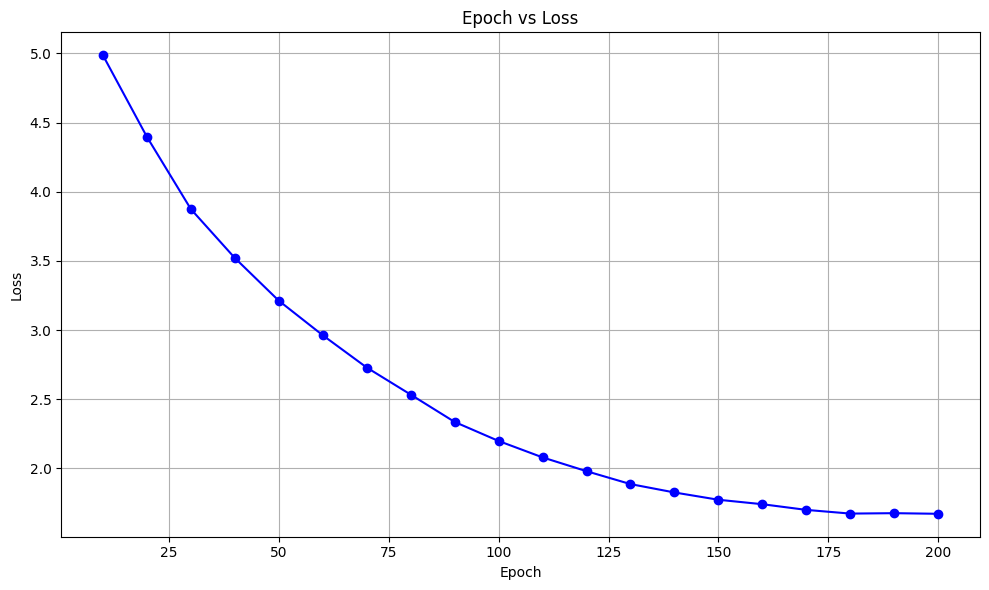

In [ ]:
import matplotlib.pyplot as plt

epochs = list(data_21_gpt.keys())
losses = list(data_21_gpt.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:\nchannel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. \nThe device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structur"

pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=3000, temperature = 0.2, top_p = 0.9)
result = pipe(prompt)
print(result[0]['generated_text'])

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:
channel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. 
The device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structurization, and the following the following parameters.





The following is a.



The following is a.

The following is a.



The following is a.



The following is a.

The following is a.



The following is a.

The following is a.


The following is a.




The following is

In [ ]:
results = trainer.evaluate()
print(results)

{'eval_loss': 3.8173675537109375, 'eval_accuracy': 0.0048828125, 'eval_bleu': 0.06304916907843652, 'eval_perplexity': 45.48391342163086, 'eval_runtime': 0.7865, 'eval_samples_per_second': 1.271, 'eval_steps_per_second': 1.271}


In [ ]:
gpt_21 = {'eval_loss': 3.8173675537109375, 'eval_accuracy': 0.0048828125, 'eval_bleu': 0.06304916907843652, 'eval_perplexity': 45.48391342163086, 'eval_runtime': 0.7865, 'eval_samples_per_second': 1.271, 'eval_steps_per_second': 1.271}

### **Code Gemma - 2B**

In [ ]:
from transformers import TrainerCallback

training_metrics = []

class MetricLoggingCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:

            step_log = logs.copy()


            if all_metrics:
                step_log.update(all_metrics[-1])


            step_log["step"] = state.global_step

            training_metrics.append(step_log)

In [ ]:
model_name = "google/codegemma-2b"

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)


device = "cuda" if torch.cuda.is_available() else "cpu"


new_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto",
)

new_model.to(device)
new_model.config.use_cache = False
new_model.config.pretraining_tp = 1


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


def tokenize_function(examples):
    combined_inputs = [f"prompt: {p} code: {c}" for p, c in zip(examples['prompt'], examples['code'])]
    return tokenizer(combined_inputs, padding=True, truncation=True, return_tensors="pt")


tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)

tokenized_test_dataset = test_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)


training_args = TrainingArguments(
    output_dir="./results",
    disable_tqdm=False,
    num_train_epochs=200,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    max_grad_norm=0.3,
    learning_rate=5e-4,
    weight_decay=0.001,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    save_steps=10,
    logging_steps=10,
    fp16=True,
    group_by_length=True,
    run_name="custom_run_name"
)


trainer = SFTTrainer(
    model=new_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    peft_config=lora_config,
    data_collator=None,
    compute_metrics = compute_metrics,
    callbacks=[MetricLoggingCallback()],
)

from functools import wraps

original_forward = new_model.forward

@wraps(original_forward)
def wrapped_forward(*args, **kwargs):
    kwargs.pop("num_items_in_batch", None)
    return original_forward(*args, **kwargs)

new_model.forward = wrapped_forward

trainer.train()

torch.cuda.empty_cache()

config.json:   0%|          | 0.00/668 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/555 [00:00<?, ?B/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Step,Training Loss
10,2.692900
20,1.734000
30,0.615500
40,0.114800
50,0.038200
60,0.023200
70,0.016500
80,0.013700
90,0.012200
100,0.011500


In [ ]:
step_loss_21_codegemma = {
    10: 3.0630, 20: 2.0049, 30: 0.8089, 40: 0.1715, 50: 0.0458,
    60: 0.0252, 70: 0.0200, 80: 0.0146, 90: 0.0127, 100: 0.0126,
    110: 0.0120, 120: 0.0116, 130: 0.0114, 140: 0.0112, 150: 0.0111,
    160: 0.0111, 170: 0.0111, 180: 0.0110, 190: 0.0110, 200: 0.0110
}

In [ ]:
step_loss_756_codegemma = {
    10: 18.9814, 20: 17.9415, 30: 15.0642, 40: 14.2612, 50: 12.8676,
    60: 11.9311, 70: 9.6576, 80: 8.7219, 90: 6.8201, 100: 6.9622,
    110: 6.3307, 120: 5.7226, 130: 5.7402, 140: 4.2773, 150: 4.8172,
    160: 3.5964, 170: 3.7612, 180: 3.2877, 190: 3.3616, 200: 2.851
}

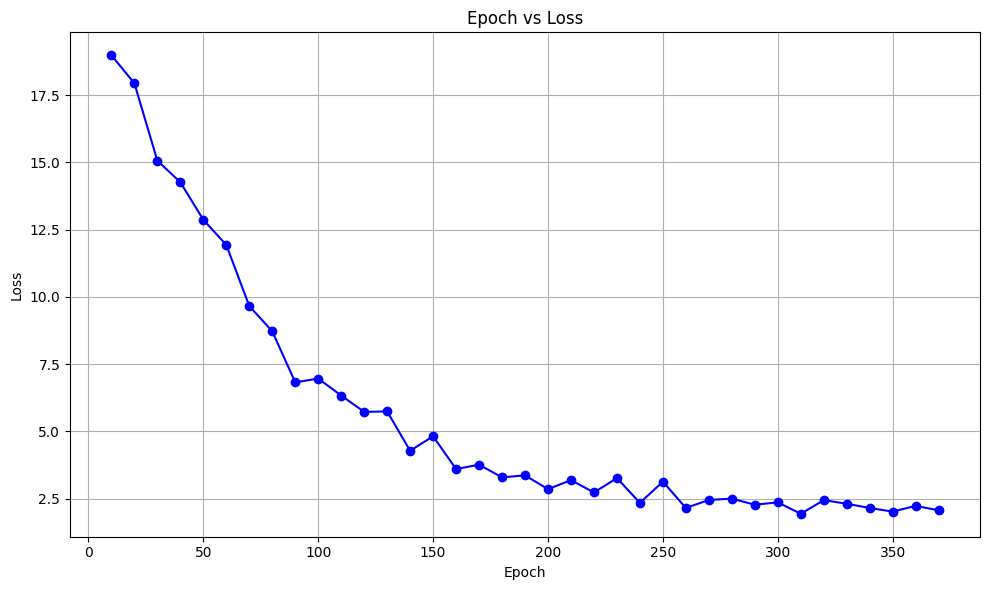

In [ ]:
import matplotlib.pyplot as plt

epochs = list(step_loss_756_codegemma.keys())
losses = list(step_loss_756_codegemma.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

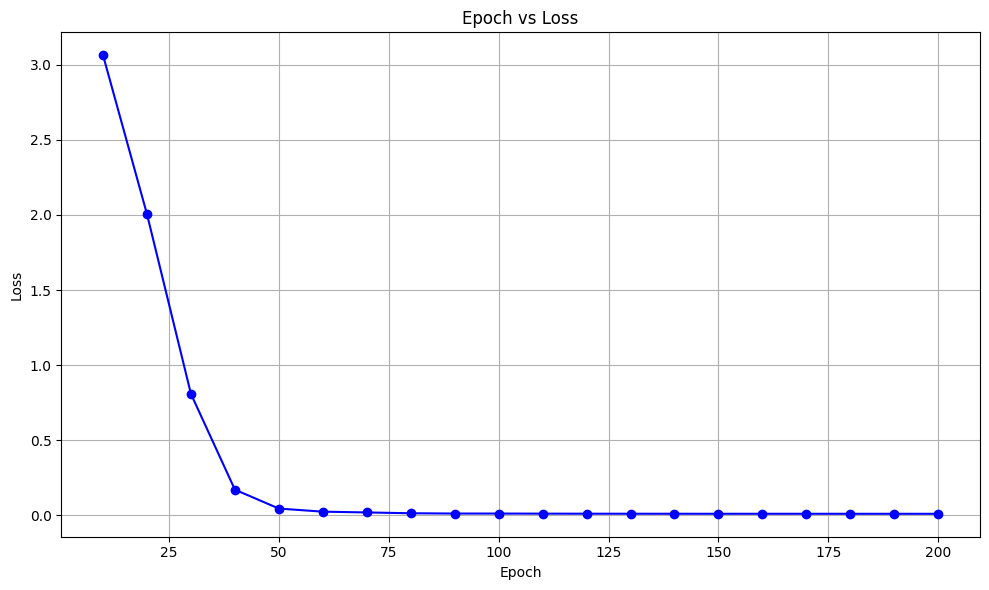

In [ ]:
epochs = list(step_loss_21_codegemma.keys())
losses = list(step_loss_21_codegemma.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
all_metrics

[{'accuracy': 0.0048828125,
  'bleu': 0.06304916907843652,
  'perplexity': 45.48391342163086}]

In [ ]:
trainer.evaluate()

{'eval_loss': 4.410696506500244,
 'eval_accuracy': 0.02734375,
 'eval_bleu': 0.14896654114485397,
 'eval_perplexity': 82.32568359375,
 'eval_runtime': 3.6577,
 'eval_samples_per_second': 0.273,
 'eval_steps_per_second': 0.273}

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:\nchannel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. \nThe device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structur"

pipe = pipeline(task="text-generation", model=new_model, tokenizer=tokenizer, max_length=2000, temperature = 0.2, top_p = 0.9, do_sample = True)
result = pipe(f"{prompt}")
print(result[0]['generated_text'])

Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:
channel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. 
The device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structur. 
The code should be modular. The initial variables block can be used in multiple parts of the structure. Meshing block can be used in multiple parts of the structure. Initialising block can be used in multiple parts of the structure. Source/Drain Epitaxy can be used in mul

In [ ]:
!huggingface-cli cache purge

usage: huggingface-cli <command> [<args>]
huggingface-cli: error: argument {download,upload,repo-files,env,login,whoami,logout,auth,repo,lfs-enable-largefiles,lfs-multipart-upload,scan-cache,delete-cache,tag,version,upload-large-folder}: invalid choice: 'cache' (choose from 'download', 'upload', 'repo-files', 'env', 'login', 'whoami', 'logout', 'auth', 'repo', 'lfs-enable-largefiles', 'lfs-multipart-upload', 'scan-cache', 'delete-cache', 'tag', 'version', 'upload-large-folder')


### **Salesforce Codegen 2B multi**

In [ ]:
model_name = "Salesforce/codegen-2B-multi"

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

codegen_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto"
)

codegen_model.to(device)
codegen_model.config.use_cache = False
codegen_model.config.pretraining_tp = 1


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"



def tokenize_function(examples):
    combined_inputs = [f"prompt: {p} code: {c}" for p, c in zip(examples['prompt'], examples['code'])]
    return tokenizer(combined_inputs, padding=True, truncation=True, return_tensors="pt")



tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)

tokenized_test_dataset = test_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)


tokenized_train_dataset = tokenized_train_dataset.remove_columns(train_dataset.column_names)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(test_dataset.column_names)


training_args = TrainingArguments(
    output_dir="./results_Codegen",
    disable_tqdm=False,
    num_train_epochs=100,
    gradient_accumulation_steps=2,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    max_grad_norm=0.3,
    learning_rate=5e-4,
    weight_decay=0.001,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    save_steps=10,
    logging_steps=10,
    fp16=True,
    group_by_length=True,
    run_name="custom_run_name"
)


trainer = SFTTrainer(
    model=codegen_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    peft_config=lora_config,
    data_collator=None,
    compute_metrics = compute_metrics
)

from functools import wraps

original_forward = codegen_model.forward

@wraps(original_forward)
def wrapped_forward(*args, **kwargs):
    kwargs.pop("num_items_in_batch", None)
    return original_forward(*args, **kwargs)

codegen_model.forward = wrapped_forward

trainer.train()

torch.cuda.empty_cache()

config.json:   0%|          | 0.00/998 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/5.69G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.69G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/240 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/1 [00:00<?, ? examples/s]

Step,Training Loss
10,2.308900
20,0.692700
30,0.033600
40,0.004500
50,0.000600
60,0.000300
70,0.000200
80,0.000200
90,0.000200
100,0.000200


In [ ]:
codegen_model.eval()
with torch.no_grad():
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

    outputs = codegen_model.generate(
        **inputs,
        max_new_tokens=100,
        do_sample=True,
        temperature=0.7,
        top_p=0.9
    )

print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:\nchannel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. \nThe device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structur"

pipe = pipeline(task="text-generation", model=codegen_model, tokenizer=tokenizer, max_length=3000, temperature = 0.2, top_p = 0.9)
result = pipe(f"{prompt}")
print(result[0]['generated_text'])

/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
step_loss_21_codegen = {
    10: 2.7364, 20: 1.0421, 30: 0.0459, 40: 0.0040, 50: 0.0005,
    60: 0.0003, 70: 0.0002, 80: 0.0001, 90: 0.0001, 100: 0.0001,
    110: 0.0001, 120: 0.0001, 130: 0.0001, 140: 0.0001, 150: 0.0001,
    160: 0.0001, 170: 0.0001, 180: 0.0001, 190: 0.0001, 200: 0.0001
}

In [ ]:
step_loss_756_codegen = {
    10: 4.5683, 20: 5.0111, 30: 3.8734, 40: 3.7292, 50: 3.7461,
    60: 3.2469, 70: 2.7269, 80: 2.0216, 90: 1.9904, 100: 2.1867,
    110: 1.5855, 120: 1.184, 130: 1.3188, 140: 1.0382, 150: 1.1443,
    160: 0.9516, 170: 0.8173, 180: 0.8039, 190: 0.6752, 200: 0.7469
}

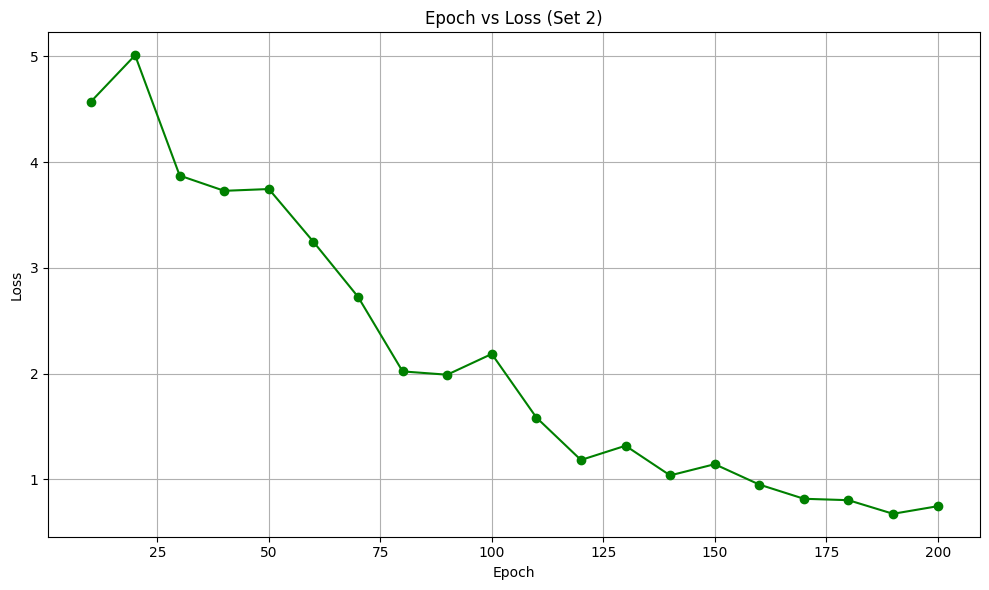

In [ ]:
epochs_2 = list(step_loss_756_codegen.keys())
losses_2 = list(step_loss_756_codegen.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs_2, losses_2, marker='o', linestyle='-', color='green')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

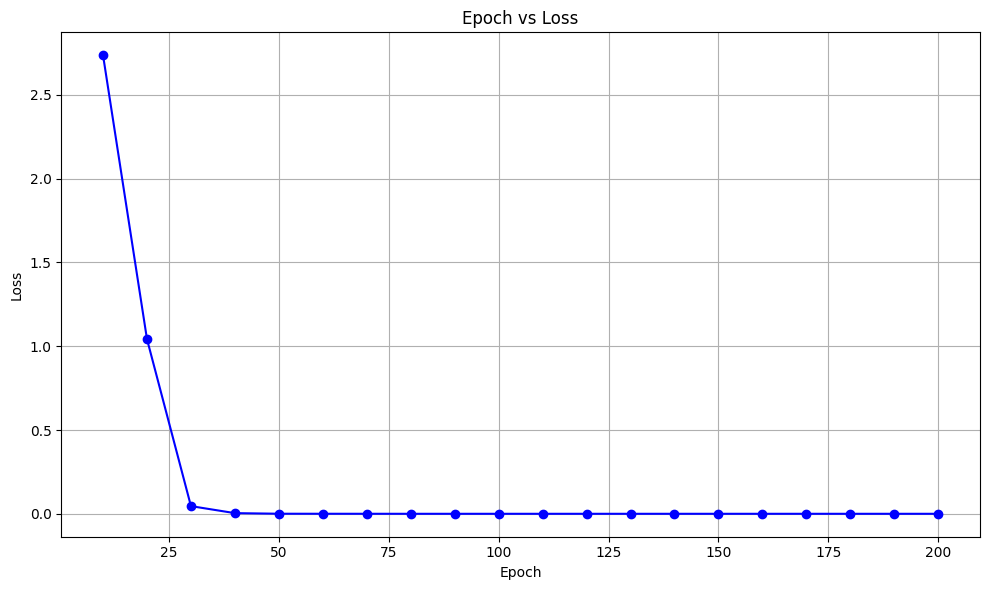

In [ ]:
epochs = list(step_loss_21_codegen.keys())
losses = list(step_loss_21_codegen.values())

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses, marker='o', linestyle='-', color='blue')
plt.title("Epoch vs Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
trainer.evaluate()

{'eval_loss': 3.107335090637207,
 'eval_accuracy': 0.00390625,
 'eval_bleu': 0.40694205026559255,
 'eval_perplexity': 22.36134147644043,
 'eval_runtime': 1.7296,
 'eval_samples_per_second': 0.578,
 'eval_steps_per_second': 0.578}

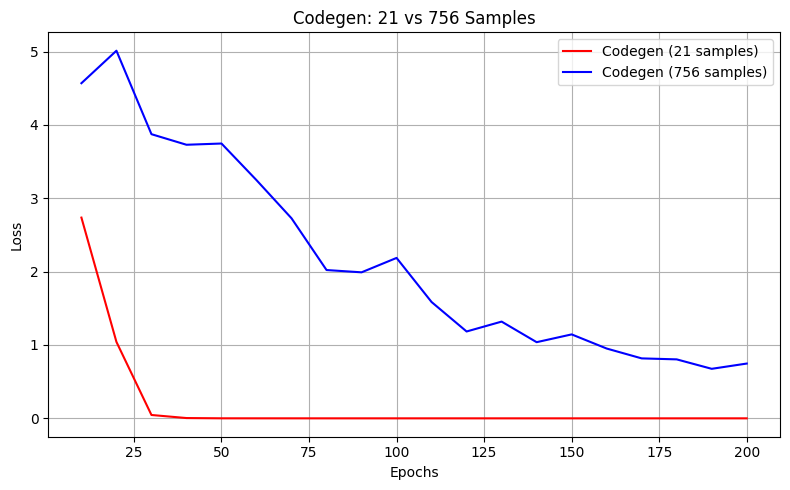

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(step_loss_21_codegen.keys(), step_loss_21_codegen.values(), label="Codegen (21 samples)", color='red')
plt.plot(step_loss_756_codegen.keys(), step_loss_756_codegen.values(), label="Codegen (756 samples)", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Codegen: 21 vs 756 Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

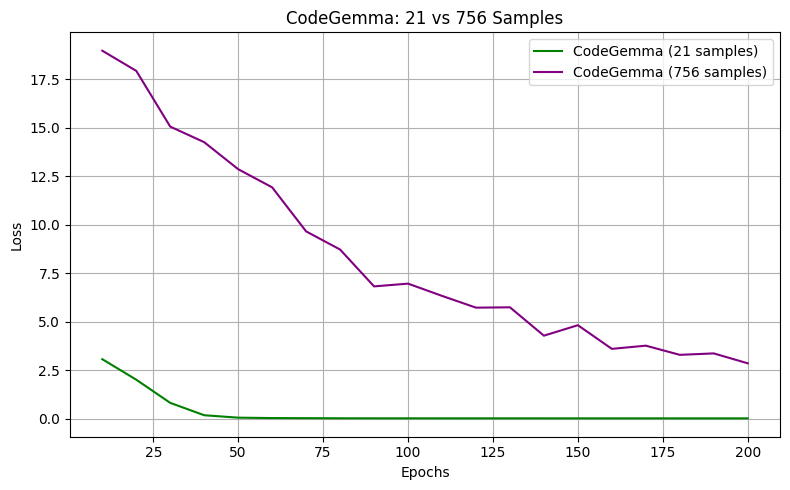

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(step_loss_21_codegemma.keys(), step_loss_21_codegemma.values(), label="CodeGemma (21 samples)", color='green')
plt.plot(step_loss_756_codegemma.keys(), step_loss_756_codegemma.values(), label="CodeGemma (756 samples)", color='purple')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CodeGemma: 21 vs 756 Samples")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

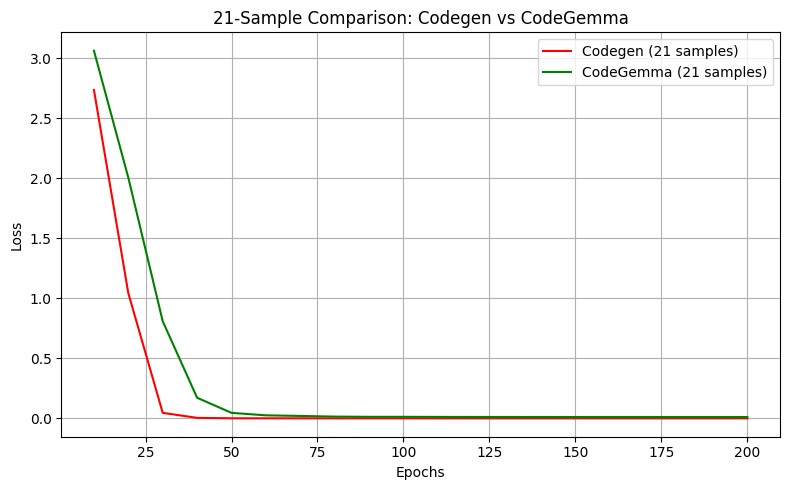

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(step_loss_21_codegen.keys(), step_loss_21_codegen.values(), label="Codegen (21 samples)", color='red')
plt.plot(step_loss_21_codegemma.keys(), step_loss_21_codegemma.values(), label="CodeGemma (21 samples)", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("21-Sample Comparison: Codegen vs CodeGemma")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

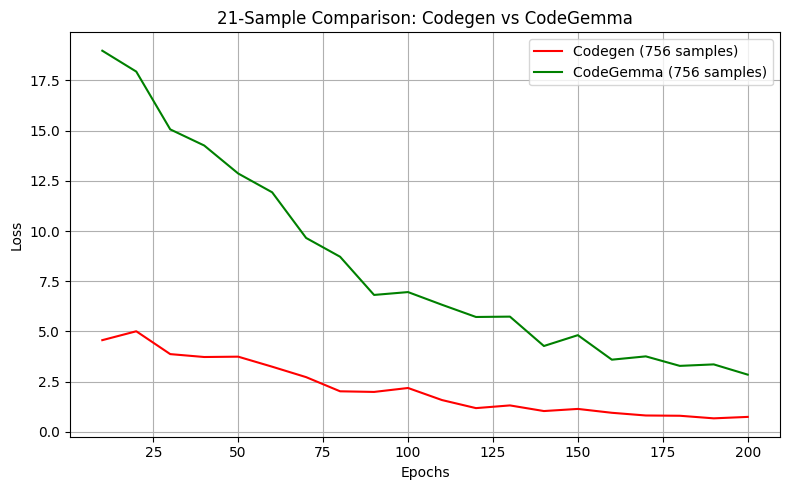

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(step_loss_756_codegen.keys(), step_loss_756_codegen.values(), label="Codegen (756 samples)", color='red')
plt.plot(step_loss_756_codegemma.keys(), step_loss_756_codegemma.values(), label="CodeGemma (756 samples)", color='green')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("21-Sample Comparison: Codegen vs CodeGemma")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
prompt = """Below are examples of sprocess code generation tasks. Use the patterns to generate code for a new request.

Examples:
1. Input: <"Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the
following specifications channel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing.
 \nThe device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow
 Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structure",

>
   Output: <mater add name=SiCh  new.like=Silicon  alt.matername=Silicon
mater add name=SiSD  new.like=Silicon  alt.matername=Silicon
mater add name=LowK  new.like=Oxide

set Nch      1.0e15  ;# channel doping
set Nsd      5.0e20  ;# SD doping
set Nstop   8e18   ;# channel stop doping

set Dch      "Boron"
set Dsd      "Phosphorus"
set Dstop    "Boron"


source user_proc.fps

proc WriteBND {} {
        global count

        if { $count < 10} {
           struct tdr.bnd=n441_0${count}
        } else {
           struct tdr.bnd=n441_${count}
        }
        set count [expr $count+1]
}
set count 1

set Type            nMOS


source PH_LIB.fps

sde off
set dx      0.2e-3                  ;# in the cross-section
set dz      1.0e-3              ;# along the channel direction

#----- Channel region name ---
set ChRegionName  Channel

# Structure parameters, [um]

set nStack   3      ;# Number of sheets
set W        0.02           ;# sheet width
set H        0.005           ;# sheet thickness/height
set tox      0.0006         ;# gate ox thickness
set thfo2    0.002256       ;# HfO2 thickness
set Lg       0.012           ;# channel length
set Ppitch   0.044 ;# Poly pitch
set FPpitch  0.029      ;# Foot print pitch: width+distance to the next NS

set Tsige    10.0e-3       ;# Distance between sheets
set Tepi     5.0e-3        ;# Epi source/drain height
set Tild     15.0e-3       ;# ILS thickness
set Tsub     [expr (100.0e-3 + ($nStack - 3)*($Tsige + $Tepi))]      ;# Substrate

set LspLK    6.0e-3       ;# LowK spacer from gate edge to source/drain epi
set Lcont    [expr ($LspLK + 1.5e-3)]        ;# LowK spacer from gate edge to source/drain contact
set Lgins    0.1e-4
set BDI      10.0e-3
set Ldiff 	 2.4e-3


### Geometry parameter consistency check ###
if { $LspLK < $Lgins } {
 puts "Check the low-k spacer length LspLK=$LspLK and Lgins=$Lgins ..."
 exit
}
if { $Ppitch < [expr ($Lg + 2*$Lcont)] } {
 puts "Poly pitch should be larger than Lg + 2*Lcont"
 exit
}
if { $FPpitch < [expr ($W + 2*($tox+$thfo2))] } {
 puts "Foot print pitch should be larger than W + 2*(tox+thfo2)"
 exit
}
if { $Tsige < [expr (2*($tox+$thfo2))] } {
 puts "Distance between sheets should be larger than 2*(tox+thfo2)"
 exit
}
if { $W < $H } {
 puts "sheet width should be larger than the thickness.."
 exit
}

#-----------------------------------------------------
# Derived dimensions
set AX0     [expr (-0.5*$H)]
set AX1     [expr ( 0.5*$H)]
set AY0     [expr (-0.5*$W)]
set AY1     [expr ( 0.5*$W)]

set P0      [expr (-0.5*$Lg)]
set P1      [expr ( 0.5*$Lg)]
set Pins0   [expr ($P0-$Lgins)]
set Pins1   [expr ($P1+$Lgins)]
set Zsp0    [expr ($P0-$LspLK)]
set Zsp1    [expr ($P1+$LspLK)]
set Zcont0  [expr ($P0-$Lcont)]
set Zcont1  [expr ($P1+$Lcont)]
set Z0      [expr (-0.5*$Ppitch)]
set Z1      [expr ( 0.5*$Ppitch)]

set Xox0    [expr ($AX0-$tox)]
set Xox1    [expr ($AX1+$tox)]
set Yox0    [expr ($AY0-$tox)]
set Yox1    [expr ($AY1+$tox)]

set Xhf0    [expr ($AX0-$tox-$thfo2)]
set Xhf1    [expr ($AX1+$tox+$thfo2)]
set Yhf0    [expr ($AY0-$tox-$thfo2)]
set Yhf1    [expr ($AY1+$tox+$thfo2)]

set Y0      [expr (-0.5*$FPpitch)]
set Y1      [expr ( 0.5*$FPpitch)]

set Hepi    [expr ($AX0-$Tepi)]
set Hild    [expr ($AX0-$Tild)]
set Hgas    [expr ($Hild-0.001)]

set P0dop   [expr ($P0-0.005)]
set P1dop   [expr ($P1+0.005)]

set BDIstart [expr ($AX0+$nStack*($H+$Tsige))]
set subdiff [expr ($BDI+$AX0+$nStack*($H+$Tsige))]


SetTDRList   {Dopants} !Solutions
#-----------------------------------------------------

# Initial Meshing
#---------------------------------------------------------------------#

line x loc=$Hgas   tag=Xgas  spacing=0.2*$Tild
line x loc=$Hild   tag=Xmin  spacing=0.2*$Tild
line x loc=$Hepi             spacing=0.2*$Tepi

line x loc=$Xhf0             spacing=4.0*$dx
line x loc=$Xox0             spacing=2.0*$dx
line x loc=$AX0              spacing=$dx
line x loc=0.5*($AX0+$AX1)   spacing=0.1*$H
line x loc=$AX1              spacing=$dx
line x loc=$Xox1             spacing=2.0*$dx
line x loc=$Xhf1             spacing=4.0*$dx
line x loc=$AX1+0.5*$Tsige   spacing=0.2*$Tsige
for {set i 1} {$i < $nStack} {incr i} {
 line x loc=$Xhf0+$i*($H+$Tsige)            spacing=4.0*$dx
 line x loc=$Xox0+$i*($H+$Tsige)            spacing=2.0*$dx
 line x loc=$AX0+$i*($H+$Tsige)             spacing=$dx
 line x loc=0.5*($AX0+$AX1)+$i*($H+$Tsige)  spacing=0.1*$H
 line x loc=$AX1+$i*($H+$Tsige)             spacing=$dx
 line x loc=$Xox1+$i*($H+$Tsige)            spacing=2.0*$dx
 line x loc=$Xhf1+$i*($H+$Tsige)            spacing=4.0*$dx
 line x loc=$AX1+$i*($H+$Tsige)+0.5*$Tsige  spacing=0.2*$Tsige
}

line x loc=$Xhf0+$nStack*($H+$Tsige)  spacing=5.0*$dx
line x loc=$Xox0+$nStack*($H+$Tsige)  spacing=5.0*$dx
line x loc=$AX0+$nStack*($H+$Tsige)   spacing=3.0*$dx

line x loc=$AX0+$nStack*($H+$Tsige)+0.5*$H   spacing=3.0*$dx

line x loc=$Tsub   tag=Xmax           spacing=0.2*$Tsub

line y loc=$Y0     tag=Ymin  spacing=8.0*$dx
line y loc=$Yhf0             spacing=4.0*$dx
line y loc=$Yox0             spacing=2.0*$dx
line y loc=$AY0              spacing=$dx
line y loc=0                 spacing=0.1*$W
line y loc=$AY1              spacing=$dx
line y loc=$Yox1             spacing=2.0*$dx
line y loc=$Yhf1             spacing=4.0*$dx
line y loc=$Y1     tag=Ymax  spacing=8.0*$dx

line z loc=$Z0     tag=Zmin  spacing=2*$dz
line z loc=$Zsp0             spacing=$dz
line z loc=$Pins0            spacing=$dz
line z loc=$P0               spacing=$dz
line z loc=$P1               spacing=$dz
line z loc=$Pins1            spacing=$dz
line z loc=$Zsp1             spacing=$dz
line z loc=$Z1     tag=Zmax  spacing=2*$dz



region Gas     xlo=Xgas xhi=Xmin ylo=Ymin yhi=Ymax zlo=Zmin zhi=Zmax
region Silicon xlo=Xmin xhi=Xmax ylo=Ymin yhi=Ymax zlo=Zmin zhi=Zmax

init





set e 0.1
for {set i 0} {$i < $nStack} {incr i} {

##-- HfO2 gate high-k

 set tx0 [expr ($Xhf0 + $i*($H+$Tsige))]
 set tx1 [expr ($Xhf1 + $i*($H+$Tsige))]
 set txm [expr 0.5*($tx0+$tx1)]

set Rhf [expr (0.5*$H+$tox+$thfo2)]
polyhedron name=hf brick= { $tx0 $Yhf0+$Rhf $Z0-$e $tx1 $Yhf1-$Rhf $Z1+$e }
polygon list
insert polyhedron=hf replace.materials= { Silicon } \
       new.material=HfO2 new.region=GateHighK_$i
PolyHedronClear

PolyHedronCylinder hf $Z0-$e $Yhf0+$Rhf $txm $Rhf $Ppitch+2*$e Z
polyhedron list
insert polyhedron=hf replace.materials= { Silicon } \
       new.material=HfO2 new.region=GateHighK_$i
PolyHedronClear

PolyHedronCylinder hf $Z0-$e $Yhf1-$Rhf $txm $Rhf $Ppitch+2*$e Z
polyhedron list
insert polyhedron=hf replace.materials= { Silicon } \
       new.material=HfO2 new.region=GateHighK_$i
PolyHedronClear

##-- Gate oxide

 set tx0 [expr ($Xox0 + $i*($H+$Tsige))]
 set tx1 [expr ($Xox1 + $i*($H+$Tsige))]
 set txm [expr 0.5*($tx0+$tx1)]
set Rox [expr (0.5*$H+$tox)]
polyhedron name=gox brick= { $tx0 $Yox0+$Rox $Z0-$e $tx1 $Yox1-$Rox $Z1+$e }
polygon list
insert polyhedron=gox replace.materials= { HfO2 } \
       new.material=Oxide new.region=GateOxide_$i
PolyHedronClear

PolyHedronCylinder gox $Z0-$e $Yox0+$Rox $txm $Rox $Ppitch+2*$e Z
polyhedron list
insert polyhedron=gox replace.materials= { HfO2 } \
       new.material=Oxide new.region=GateOxide_$i
PolyHedronClear

PolyHedronCylinder gox $Z0-$e $Yox1-$Rox $txm $Rox $Ppitch+2*$e Z
polyhedron list
insert polyhedron=gox replace.materials= { HfO2 } \
       new.material=Oxide new.region=GateOxide_$i
PolyHedronClear

##-- Si Nano-slab

 set tx0 [expr ($AX0 + $i*($H+$Tsige))]
 set tx1 [expr ($AX1 + $i*($H+$Tsige))]
 set txm [expr 0.5*($tx0+$tx1)]
set Rns [expr (0.5*$H)]
polyhedron name=ns brick= { $tx0 $AY0+$Rns $Z0-$e $tx1 $AY1-$Rns $Z1+$e }
polygon list
insert polyhedron=ns replace.materials= { Oxide } \
       new.material=SiCh new.region=${ChRegionName}_$i
PolyHedronClear

PolyHedronCylinder ns $Z0-$e $AY0+$Rns $txm $Rns $Ppitch+2*$e Z
polyhedron list
insert polyhedron=ns replace.materials= { Oxide } \
       new.material=SiCh new.region=${ChRegionName}_$i
PolyHedronClear

PolyHedronCylinder ns $Z0-$e $AY1-$Rns $txm $Rns $Ppitch+2*$e Z
polyhedron list
insert polyhedron=ns replace.materials= { Oxide } \
       new.material=SiCh new.region=${ChRegionName}_$i
PolyHedronClear





}
if { $debug } { WriteBND }


### STI
set tx0 [expr ($BDI+$AX0+$nStack*($H+$Tsige))]
set tx1 [expr ($tx0+0.050)]
polyhedron name=sti brick= { $tx0 $AY1 $Z0-$e $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=sti replace.materials= { Silicon } \
       new.material=Oxide new.region=STI
PolyHedronClear
polyhedron name=sti brick= { $tx0 $Y0-$e $Z0-$e $tx1 $AY0 $Z1+$e }
polygon list
insert polyhedron=sti replace.materials= { Silicon } \
       new.material=Oxide new.region=STI
PolyHedronClear
if { $debug } { WriteBND }




### BDI
set tx0 [expr ($AX0+$nStack*($H+$Tsige))]
set tx1 [expr ($tx0+$BDI)]
polyhedron name=sti brick= { $tx0 $Y0-$e $Z0-$e $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=sti replace.materials= { Silicon } \
       new.material=Nitride new.region=BDI
PolyHedronClear

if { $debug } { WriteBND }


### LowK spacer
set tx0 $Hild
set tx1 [expr ($AX0+$nStack*($H+$Tsige))]

polyhedron name=lowk brick= { $tx0 $Y0-$e $P1 $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=lowk replace.materials= { Silicon } \
       new.material=LowK new.region=SPd
PolyHedronClear
polyhedron name=lowk brick= { $tx0 $Y0-$e $P1 $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=lowk replace.materials= { HfO2 Oxide } \
       new.material=LowK new.region=SPd
PolyHedronClear

polyhedron name=lowk brick= { $tx0 $Y0-$e $Z0-$e $tx1 $Y1+$e $P0 }
polygon list
insert polyhedron=lowk replace.materials= { Silicon } \
       new.material=LowK new.region=SPs
PolyHedronClear
polyhedron name=lowk brick= { $tx0 $Y0-$e $Z0-$e $tx1 $Y1+$e $P0 }
polygon list
insert polyhedron=lowk replace.materials= { HfO2 Oxide} \
       new.material=LowK new.region=SPs
PolyHedronClear
if { $debug } { WriteBND }


### source/drain epi
set tx0 $Hepi
set tx1 [expr ($AX0+$nStack*($H+$Tsige))]
polyhedron name=epi brick= { $tx0 $Y0-$e $Zsp1 $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=epi replace.materials= { LowK Oxide } \
       new.material=SiSD new.region=dEpi
PolyHedronClear
polyhedron name=epi brick= { $tx0 $Y0-$e $Z0-$e $tx1 $Y1+$e $Zsp0 }
polygon list
insert polyhedron=epi replace.materials= { LowK Oxide } \
       new.material=SiSD new.region=sEpi
PolyHedronClear
if { $debug } { WriteBND }

### Gate metal
set tx0 $Hild
set tx1 [expr ($AX0+$nStack*($H+$Tsige))]
polyhedron name=gm brick= { $tx0 $Y0-$e $Zsp0 $tx1 $Y1+$e $Zsp1 }
polygon list
insert polyhedron=gm replace.materials= { Silicon } \
       new.material=Tungsten new.region=GateMetal
PolyHedronClear
if { $debug } { WriteBND }


set tx0 $Hild
set tx1 [expr ($AX0+$nStack*($H+$Tsige))]
polyhedron name=cont brick= { $tx0 $Y0-$e $Zcont1 $tx1 $Y1+$e $Z1+$e }
polygon list
insert polyhedron=cont replace.materials= { LowK } \
       new.material=Tungsten new.region=dMetal
PolyHedronClear
polyhedron name=cont brick= { $tx0 $Y0-$e $Z0-$e $tx1 $Y1+$e $Zcont0 }
polygon list
insert polyhedron=cont replace.materials= { LowK } \
       new.material=Tungsten new.region=sMetal
PolyHedronClear
if { $debug } { WriteBND }

#----- Contact for sdevice simulation -----
contact point replace region=GateMetal    name=gate
contact point replace region=sMetal       name=source
contact point replace region=dMetal       name=drain

WriteBND
struct tdr= n441_mesh_fps.tdr !Gas !interfaces !alt.maternames pdb !bnd !Adaptive

#####-------------------------#####
#####--- Transistor Doping ---#####
#####-------------------------#####
select name=$Dch    SiCh  store  z=$Nch
select name=$Dch    SiSD  store  z=$Nch
select name=$Dsd    SiCh  store  \
       z=(z>0)?((z>$P1dop)?$Nsd:($Nsd*erfc(-1*(z-$P1dop)/$Ldiff))):((z<$P0dop)?$Nsd:($Nsd*erfc((z-$P0dop)/$Ldiff)))
select name=$Dsd    SiSD  store  z=$Nsd
select name=$Dstop  Silicon  store  z=$Nstop

#######--- Diffusion ---#####
AdvancedCalibration


diffuse time= 1.0e-6<s> temp= 500 !stress.relax

select name=DopingConcentration SiCh  store  z="NetActive"
select name=DopingConcentration SiSD  store  z="NetActive"
select name=DopingConcentration Silicon  store  z="NetActive"

####Generate Final Structure
SetTDRList   {DopingConcentration NetActive AsActive BActive PActive} !Solutions
struct tdr= n441_fps.tdr !Gas !interfaces alt.maternames !pdb !bnd>




2. Input: <Write the sprocess code to create a 3D silicon channel FinFET device without using actual process flow and using polyhedrons with the following specifications: channel doping 1.0e15/cm3, Source Drain doping 5e20/cm3,
 Fin Height 40nm, Fin Width 10nm, 0.6nm SiO2, 2nm HfO2, 12nm Gate length, 15nm Fin-to-fin spacing. The device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si fins,
 Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structure.
>

   Output: <# ===========================
# Initial Variables
# ===========================
set finHeight 40        # nm
set finWidth 10         # nm
set gateLength 12       # nm
set finSpacing 15       # nm
set tox_SiO2 0.6        # nm
set tox_HfO2 2.0        # nm
set doping_channel 1.0e15  # cm^-3
set doping_sourceDrain 5.0e20  # cm^-3

# ===========================
# Meshing
# ===========================
Mesh3D {
    x.mesh loc = 0 spacing = 2
    x.mesh loc = $gateLength spacing = 2
    x.mesh loc = [expr {$gateLength + $finSpacing}] spacing = 2
    y.mesh loc = 0 spacing = 2
    y.mesh loc = $finWidth spacing = 2
    z.mesh loc = 0 spacing = 2
    z.mesh loc = $finHeight spacing = 2
}

# ===========================
# Initializing the Simulation
# ===========================
Init Structure3D {
    region Silicon doping = $doping_channel material = Silicon
}

# ===========================
# Creating the Si Fin
# ===========================
AddPolyhedron Region=Silicon Doping=$doping_channel {
    Vertex 0 0 0
    Vertex 0 $finWidth 0
    Vertex $gateLength $finWidth 0
    Vertex $gateLength 0 0
    Vertex 0 0 $finHeight
    Vertex 0 $finWidth $finHeight
    Vertex $gateLength $finWidth $finHeight
    Vertex $gateLength 0 $finHeight
}

# ===========================
# Creating the Gate Oxide (SiO2)
# ===========================
AddPolyhedron Region=Oxide Material=SiO2 {
    Vertex -$tox_SiO2 -$tox_SiO2 0
    Vertex -$tox_SiO2 [expr {$finWidth + $tox_SiO2}] 0
    Vertex [expr {$gateLength + $tox_SiO2}] [expr {$finWidth + $tox_SiO2}] 0
    Vertex [expr {$gateLength + $tox_SiO2}] -$tox_SiO2 0
    Vertex -$tox_SiO2 -$tox_SiO2 [expr {$finHeight + $tox_SiO2}]
    Vertex -$tox_SiO2 [expr {$finWidth + $tox_SiO2}] [expr {$finHeight + $tox_SiO2}]
    Vertex [expr {$gateLength + $tox_SiO2}] [expr {$finWidth + $tox_SiO2}] [expr {$finHeight + $tox_SiO2}]
    Vertex [expr {$gateLength + $tox_SiO2}] -$tox_SiO2 [expr {$finHeight + $tox_SiO2}]
}

# ===========================
# Creating the High-k Dielectric (HfO2)
# ===========================
AddPolyhedron Region=Highk Material=HfO2 {
    Vertex -$tox_HfO2 -$tox_HfO2 0
    Vertex -$tox_HfO2 [expr {$finWidth + $tox_HfO2}] 0
    Vertex [expr {$gateLength + $tox_HfO2}] [expr {$finWidth + $tox_HfO2}] 0
    Vertex [expr {$gateLength + $tox_HfO2}] -$tox_HfO2 0
    Vertex -$tox_HfO2 -$tox_HfO2 [expr {$finHeight + $tox_HfO2}]
    Vertex -$tox_HfO2 [expr {$finWidth + $tox_HfO2}] [expr {$finHeight + $tox_HfO2}]
    Vertex [expr {$gateLength + $tox_HfO2}] [expr {$finWidth + $tox_HfO2}] [expr {$finHeight + $tox_HfO2}]
    Vertex [expr {$gateLength + $tox_HfO2}] -$tox_HfO2 [expr {$finHeight + $tox_HfO2}]
}

# ===========================
# Creating the Source Region (Left)
# ===========================
AddPolyhedron Region=Silicon Doping=$doping_sourceDrain {
    Vertex [expr {- $gateLength}] 0 0
    Vertex [expr {- $gateLength}] $finWidth 0
    Vertex 0 $finWidth 0
    Vertex 0 0 0
    Vertex [expr {- $gateLength}] 0 $finHeight
    Vertex [expr {- $gateLength}] $finWidth $finHeight
    Vertex 0 $finWidth $finHeight
    Vertex 0 0 $finHeight
}

# ===========================
# Creating the Drain Region (Right)
# ===========================
AddPolyhedron Region=Silicon Doping=$doping_sourceDrain {
    Vertex [expr {$gateLength}] 0 0
    Vertex [expr {$gateLength}] $finWidth 0
    Vertex [expr {$gateLength * 2}] $finWidth 0
    Vertex [expr {$gateLength * 2}] 0 0
    Vertex [expr {$gateLength}] 0 $finHeight
    Vertex [expr {$gateLength}] $finWidth $finHeight
    Vertex [expr {$gateLength * 2}] $finWidth $finHeight
    Vertex [expr {$gateLength * 2}] 0 $finHeight
}

# ===========================
# Creating the Gate Metal
# ===========================
AddPolyhedron Region=Metal Material=Aluminum {
    Vertex 0 0 [expr {$finHeight + $tox_SiO2}]
    Vertex 0 $finWidth [expr {$finHeight + $tox_SiO2}]
    Vertex $gateLength $finWidth [expr {$finHeight + $tox_SiO2}]
    Vertex $gateLength 0 [expr {$finHeight + $tox_SiO2}]
    Vertex 0 0 [expr {$finHeight + $tox_SiO2 + 5}]
    Vertex 0 $finWidth [expr {$finHeight + $tox_SiO2 + 5}]
    Vertex $gateLength $finWidth [expr {$finHeight + $tox_SiO2 + 5}]
    Vertex $gateLength 0 [expr {$finHeight + $tox_SiO2 + 5}]
}

# ===========================
# Saving the Structure
# ===========================
Save Structure file=\"finfet_3D.tdr\">

...

New Task:
Input: Write the sprocess code to create a 3D Gate-All-Around FET device without using actual process flow and using polyhedrons with the following specifications:
channel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 4 nanowires, 10nm nanowire diameter, 0.6nm SiO2, 2.256nm HfO2, 15nm Gate length, 8nm nanowire spacing.
The device will have source, drain, and gate contacts.
The code should be parametric. Different blocks to realize the structure include:
- Initial variables
- Meshing
- Initializing
- Creating HfO2
- Gate Oxide (SiO2)
- Si nanowires
- Shallow Trench Isolation (STI)
- Buried Dielectric Isolation (BDI)
- Spacer
- Source/Drain Epitaxy
- Gate Metal
- Contacts
- Doping
- Diffusion
- Saving structure

Output:
"""

response = codegen_model.generate(prompt)
print(response)


In [ ]:
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")
print("Capability:", torch.cuda.get_device_capability(0) if torch.cuda.is_available() else "N/A")

Torch version: 2.5.1+cu124
CUDA available: True
CUDA version: 12.4
Device: Tesla T4
Capability: (7, 5)


In [ ]:
print("Default torch dtype:", torch.get_default_dtype())
print("Available dtypes:", dir(torch))

Default torch dtype: torch.float32
Available dtypes: ['AVG', 'AggregationType', 'AliasDb', 'AnyType', 'Argument', 'ArgumentSpec', 'AwaitType', 'BFloat16Storage', 'BFloat16Tensor', 'BenchmarkConfig', 'BenchmarkExecutionStats', 'Block', 'BoolStorage', 'BoolTensor', 'BoolType', 'BufferDict', 'ByteStorage', 'ByteTensor', 'CallStack', 'Capsule', 'CharStorage', 'CharTensor', 'ClassType', 'Code', 'CompilationUnit', 'CompleteArgumentSpec', 'ComplexDoubleStorage', 'ComplexFloatStorage', 'ComplexType', 'ConcreteModuleType', 'ConcreteModuleTypeBuilder', 'DeepCopyMemoTable', 'DeserializationStorageContext', 'DeviceObjType', 'DictType', 'DisableTorchFunction', 'DisableTorchFunctionSubclass', 'DispatchKey', 'DispatchKeySet', 'DoubleStorage', 'DoubleTensor', 'EnumType', 'ErrorReport', 'Event', 'ExcludeDispatchKeyGuard', 'ExecutionPlan', 'FatalError', 'FileCheck', 'FloatStorage', 'FloatTensor', 'FloatType', 'FunctionSchema', 'Future', 'FutureType', 'Generator', 'GradScaler', 'Gradient', 'Graph', 'Grap

In [ ]:
bnb_config_1 = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True
)

In [ ]:
model_name = "deepseek-ai/DeepSeek-R1-Zero"

lora_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=128,
    bias="none",
    task_type="CAUSAL_LM",
)


device = "cuda" if torch.cuda.is_available() else "cpu"

deepseek_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_1,
    trust_remote_code = True,
    device_map="auto"
)


deepseek_model.to(device)
deepseek_model.config.use_cache = False
deepseek_model.config.pretraining_tp = 1


tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


def tokenize_function(examples):

    combined_inputs = [f"prompt: {p} code: {c}" for p, c in zip(examples['prompt'], examples['code'])]
    return {"text": combined_inputs}



tokenized_train_dataset = train_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)

tokenized_test_dataset = test_dataset.map(
    tokenize_function, batched=True, batch_size=16, load_from_cache_file=False
)


tokenized_train_dataset = tokenized_train_dataset.remove_columns(train_dataset.column_names)
tokenized_test_dataset = tokenized_test_dataset.remove_columns(test_dataset.column_names)


training_args = TrainingArguments(
    output_dir="./results",
    disable_tqdm=False,
    num_train_epochs=1,
    gradient_accumulation_steps=8,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    max_grad_norm=0.3,
    learning_rate=5e-4,
    weight_decay=0.001,
    optim="paged_adamw_32bit",
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    save_steps=1,
    logging_steps=10,
    fp16=True,
    group_by_length=True,
    run_name="custom_run_name"
)


trainer = SFTTrainer(
    model=deepseek_model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    peft_config=lora_config,
    data_collator=None,
    tokenizer = tokenizer
)

from functools import wraps

original_forward = deepseek_model.forward

@wraps(original_forward)
def wrapped_forward(*args, **kwargs):
    kwargs.pop("num_items_in_batch", None)
    return original_forward(*args, **kwargs)

deepseek_model.forward = wrapped_forward

trainer.train()

torch.cuda.empty_cache()

config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

configuration_deepseek.py:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-R1-Zero:
- configuration_deepseek.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_deepseek.py:   0%|          | 0.00/75.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/deepseek-ai/DeepSeek-R1-Zero:
- modeling_deepseek.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


ValueError: Unknown quantization type, got fp8 - supported types are: ['awq', 'bitsandbytes_4bit', 'bitsandbytes_8bit', 'gptq', 'aqlm', 'quanto', 'eetq', 'higgs', 'hqq', 'compressed-tensors', 'fbgemm_fp8', 'torchao', 'bitnet', 'vptq']

In [ ]:
print("Torch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("Default torch dtype:", torch.get_default_dtype())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

try:
    from bitsandbytes import __version__ as bnb_version
    print("BitsAndBytes version:", bnb_version)
except ImportError:
    print("BitsAndBytes not installed.")

try:
    from accelerate.utils import get_accelerate_config
    print("Accelerate Config:", get_accelerate_config())
except ImportError:
    print("Accelerate not installed.")

Torch version: 2.5.1+cu124
CUDA version: 12.4
Default torch dtype: torch.float32
Device: Tesla T4
BitsAndBytes version: 0.45.2
Accelerate not installed.


In [ ]:
from peft import PeftModel

In [ ]:
from transformers import AutoModelForCausalLM

base_model = AutoModelForCausalLM.from_pretrained("google/codegemma-2b")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# model_name = "NousResearch/Llama-2-7b-chat-hf"

In [ ]:
model_name = "google/codegemma-2b"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)

prompt = "Write the sprocess code to create a 3D silicon channel Nanosheet FET device without using actual process flow and using polyhedrons with the following specifications:\nchannel doping 1.0e15/cm3, Source Drain doping 5e20/cm3, 3 Sheets, 20nm Sheet Width, 5nm Sheet thickness, 0.6nm SiO2, 2.256nm HfO2, 12nm Gate length, 10nm sheet to sheet spacing. \nThe device will have source, drain and gate contacts. The code should be parametric. Different blocks to realise the structure are for initial variables, meshing, initialising, creating HfO2, Gate Oxide (SiO2), Si sheets, Shallow Trench Isolation (STI), Buried Dielectric Isolation (BDI), Spacer, Source/Drain Epitaxy, Gate Metal, Contacts, Doping, Diffusion and saving structure"
result = pipe(prompt, max_new_tokens=1500, do_sample=True)
print(result[0]['generated_text'])


In [ ]:
# del model
import gc
gc.collect()
gc.collect()

0

In [ ]:
trainer.model.save_pretrained(new_model)

In [ ]:
logging.set_verbosity(logging.CRITICAL)

prompt = "What is a large language model?"
pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=200)
result = pipe(f"<s>[INST] {prompt} [/INST]")
print(result[0]['generated_text'])

In [ ]:
import gc
gc.collect()
gc.collect()

0

In [ ]:
!du -h --max-depth=1 /content

140K	/content/.config
72K	/content/results
55M	/content/sample_data
68M	/content


In [ ]:
!rm -rf /content/results/checkpoint-*

In [ ]:
!rm -rf /root/.cache/huggingface/
torch.cuda.empty_cache()

In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   34G  203G  15% /
tmpfs            64M     0   64M   0% /dev
shm              25G  4.0K   25G   1% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
/dev/sda1       242G  173G   70G  72% /opt/bin/.nvidia
tmpfs            26G  9.0M   26G   1% /var/colab
tmpfs            26G     0   26G   0% /proc/acpi
tmpfs            26G     0   26G   0% /proc/scsi
tmpfs            26G     0   26G   0% /sys/firmware


In [ ]:
!du -h --max-depth=1 /opt/bin/.nvidia | sort -hr

7.4M	/opt/bin/.nvidia
